# **뉴스기사 요약해보기**

In [1]:
!pip install --upgrade summa
!pip install --upgrade nltk #3.9.1

In [2]:
from importlib.metadata import version
import nltk
import torch
import summa
import pandas as pd

print(nltk.__version__)
print(torch.__version__)
print(pd.__version__)
print(version('summa'))

3.9.2
2.10.0+cu128
3.0.0
1.2.0


## **Step 1. 데이터 수집하기**

In [3]:
import nltk
nltk.download('stopwords')  # 불필요한 단어 목록을 다운로드

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords  # 위에서 다운받은 stopwords를 실제로 쓰기 위해 불러오는 것
from bs4 import BeautifulSoup  # HTML 파싱용

import torch
from collections import Counter

import urllib.request  # 인터넷에서 데이터 다운로드할 때 사용
import warnings  # 경고 메시지 숨기기용으로 사
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')  # BeautifulSoup 관련 경고 안 뜨게 막는 코드

print('=3')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jjeong3150/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [5]:
data.sample(10)

,headlines,text
54584,Four prisoners escape from German jail through...,The German police on Thursday launched a searc...
74653,Russia bans Christian sect as extremist organi...,Russia has banned the Christian sect Jehovah's...
52085,Sisters steal baby to stop father from remarrying,The police arrested two sisters on Monday for ...
78830,Airtel profit plunges 75% to Ã¢ÂÂ¹367 crore i...,Country's largest telecom operator Bharti Airt...
5954,"Delhi HC rejects Vodafone plea for Ã¢ÂÂ¹4,759...",The Delhi High Court has dismissed Vodafone's ...
41487,Pakistan dropped Sachin 4 times to lose 2011 W...,Sachin Tendulkar was dropped four times during...
6353,Dissolution of Sri Lanka Parliament by Prez il...,Sri Lanka's Supreme Court has called the Parli...
95315,10 feared dead in explosion at Russian metro s...,At least 10 people are feared dead and 50 othe...
89845,10-year-old girl fights off alligator by hitti...,"A 10-year-old girl in Florida, United States m..."
9681,Lalu's health worsens; he can't sit or stand o...,After meeting RJD supremo Lalu Prasad Yadav in...


## **Step 2. 데이터 전처리하기 (추상적 요약)**

In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# 데이터프레임에 Null 값이 있는지 확인

print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
# Null 제거

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [13]:
# 전처리 함수 테스트 해보기

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


### **전처리 실행**

In [14]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [15]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_summary = []

for sentence in data['headlines']:
    clean_summary.append(preprocess_sentence(sentence, remove_stopwords=False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [16]:
# 전처리 된 데이터로 변경
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [17]:
# Null 값 생겼는지 확인

data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
# Null 값 포함한 데이터 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### **훈련데이터와 테스트데이터 나누기**

#### **샘플의 최대 길이 정하기**

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


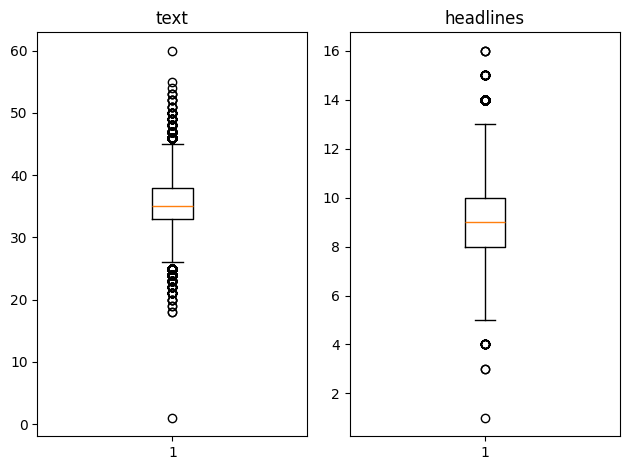

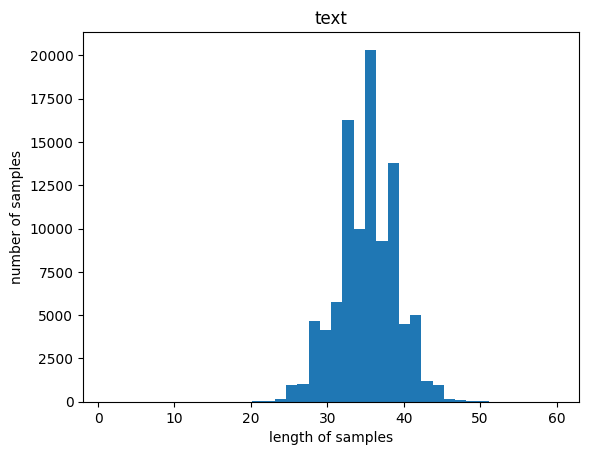

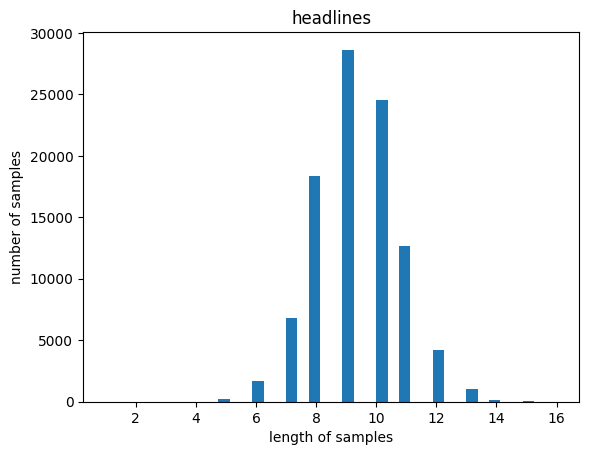

In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
text_max_len = 60
summary_max_len = 16
print('=3')

# 데이터 길이가 적절해서 그대로 써도 될듯

=3


In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len, data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [23]:
# data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
# data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]

# print('전체 샘플수 :', (len(data)))

In [24]:
data.text

0        saurav kant alumnus upgrad iiit pg program mac...
1        kunal shah credit card bill payment platform c...
2        new zealand defeated india wickets fourth odi ...
3        aegon life iterm insurance plan customers enjo...
4        speaking sexual harassment allegations rajkuma...
                               ...                        
98396    crpf jawan tuesday axed death sharp edged weap...
98397    uff yeh first song sonakshi sinha starrer upco...
98398    according reports new version science fiction ...
98399    new music video shows rapper snoop dogg aiming...
98400    madhesi morcha alliance seven political partie...
Name: text, Length: 98360, dtype: str

In [25]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [26]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


#### **훈련 데이터와 테스트 데이터 분리**

In [27]:
encoder_input.shape[0]

98360

In [28]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

# 0 ~ encoder_input.shape[0] 까지의 랜덤한 정수 배열을 만듦
# 즉, 데이터 개수만큼 인덱스를 만든 뒤, 순서를 랜덤으로 섞는 코드

[31672  8992 83495 ... 12667 34881 67179]


In [29]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [30]:
# 훈련 데이터와 테스트 데이터를 8:2 비율로 나누기
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [31]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### **정수 인코딩**

#### **단어 집합(vocabulary) 만들기 및 정수 인코딩**

In [32]:
def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [33]:
src_vocab

{'<PAD>': 0,
 '<UNK>': 1,
 'said': 2,
 'india': 3,
 'year': 4,
 'added': 5,
 'us': 6,
 'also': 7,
 'first': 8,
 'government': 9,
 'police': 10,
 'people': 11,
 'two': 12,
 'indian': 13,
 'old': 14,
 'minister': 15,
 'film': 16,
 'president': 17,
 'one': 18,
 'crore': 19,
 'world': 20,
 'court': 21,
 'state': 22,
 'years': 23,
 'would': 24,
 'reportedly': 25,
 'new': 26,
 'former': 27,
 'time': 28,
 'delhi': 29,
 'last': 30,
 'three': 31,
 'reports': 32,
 'company': 33,
 'like': 34,
 'based': 35,
 'earlier': 36,
 'congress': 37,
 'bjp': 38,
 'man': 39,
 'country': 40,
 'team': 41,
 'claimed': 42,
 'pakistan': 43,
 'modi': 44,
 'trump': 45,
 'day': 46,
 'accused': 47,
 'chief': 48,
 'pm': 49,
 'singh': 50,
 'women': 51,
 'actor': 52,
 'million': 53,
 'allegedly': 54,
 'made': 55,
 'according': 56,
 'wednesday': 57,
 'pradesh': 58,
 'friday': 59,
 'party': 60,
 'tuesday': 61,
 'comes': 62,
 'monday': 63,
 'lakh': 64,
 'woman': 65,
 'called': 66,
 'video': 67,
 'around': 68,
 'asked': 69,


In [34]:
threshold = 7

# 전처리된 데이터 사용
text_data = data['text'].tolist()
summary_data = data['headlines'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 76334
등장 빈도가 6번 이하인 희귀 단어의 수: 51776
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24558
단어 집합에서 희귀 단어의 비율: 67.82822857442294
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0337692130558263


In [35]:
src_vocab_size = 24000

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)
print('=3')

=3


In [36]:
len(src_vocab)

24000

In [37]:
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[415, 643, 9, 2452, 839, 360, 495, 722, 409, 1321, 22, 113, 494, 10481, 78, 2054, 1828, 2, 11, 323, 203, 4727, 330, 355, 4653, 2224, 5, 379, 1015, 1271, 11, 22, 6006, 360, 722], [1217, 1610, 70, 95, 27, 357, 432, 4893, 18367, 1636, 1745, 202, 1819, 703, 15358, 28, 1030, 705, 8433, 18367, 2, 4583, 2737, 1636, 1745, 202, 95, 490, 1143, 903, 1791, 62, 375, 32, 210, 742, 1039, 2185, 147, 1254, 1410, 9865, 788], [133, 4980, 8434, 6617, 205, 67, 13809, 1778, 5655, 8280, 10742, 335, 449, 6339, 2906, 658, 8280, 2, 497, 3206, 2907, 3157, 203, 178, 1799, 8280, 7, 205, 4584, 397, 294, 874, 680, 1053]]
[[379, 406, 41, 259, 400, 986, 3431, 4751, 628, 79, 4249, 3647, 3759, 4267, 1000, 595, 147, 1843, 1572, 8520, 241, 13489, 426, 1, 1507, 881, 39, 2355, 4110, 767, 15113, 3104, 10, 196, 2583, 12701, 7540, 1000], [6, 292, 530, 594, 196, 5612, 8, 220, 300, 994, 2706, 1114, 23, 402, 362, 994, 5006, 1536, 1082, 3421, 9026, 1, 1558, 21583, 3611, 5784, 1, 3421, 21200, 1114, 216, 1905, 278, 1401, 493, 362],

##### **Summary 데이터에 대해서도 동일한 작업 수행**

In [38]:
def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)
print('=3')

=3


In [39]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30076
등장 빈도가 5번 이하인 희귀 단어의 수: 19662
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10414
단어 집합에서 희귀 단어의 비율: 65.37438489160793
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.650390935864803


In [40]:
tar_vocab_size = 10000
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 50, 210, 1270, 6, 633, 2547, 5, 3306, 901, 40], [2, 7763, 1, 525, 605, 706, 342, 239, 4, 756, 5, 1673], [2, 225, 2411, 1, 9119, 6774, 5147, 1], [2, 273, 6388, 19, 2861, 129, 859, 7, 5778, 3136, 95, 1], [2, 1825, 1007, 845, 620, 8, 4065, 158, 3501, 74]]
target
decoder  [[50, 210, 1270, 6, 633, 2547, 5, 3306, 901, 40, 3], [7763, 1, 525, 605, 706, 342, 239, 4, 756, 5, 1673, 3], [225, 2411, 1, 9119, 6774, 5147, 1, 3], [273, 6388, 19, 2861, 129, 859, 7, 5778, 3136, 95, 1, 3], [1825, 1007, 845, 620, 8, 4065, 158, 3501, 74, 3]]


In [41]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


#### **패딩하기**

In [42]:
from torch.nn.utils.rnn import pad_sequence

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=summary_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=summary_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=summary_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=summary_max_len)

print('=3')

=3


## **Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)**

In [43]:
import torch.nn as nn
import torch.nn.functional as F

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
src_vocab_size = len(src_vocab)  # 단어 집합 크기

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [44]:
# 디코더 설계
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [45]:
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

# 모델 생성
model_A = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)
print(model_A)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(24000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10000, bias=True)
)


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_A = model_A.to(device)

In [47]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model_A.to(device)

# Hyperparameters
batch_size = 256
epochs = 50
learning_rate = 0.001
patience = 2

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer_A = optim.AdamW(model_A.parameters(), lr=learning_rate)

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [126]:


# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    train_losses = []
    val_losses = []
    
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

    return train_losses, val_losses

In [49]:
%%time
# 30분 이상 시간이 걸릴 수 있습니다. GPU 환경에서 학습하는 것을 권장합니다.
# 학습 실행
train_model(model_A, train_loader, test_loader, criterion, optimizer_A, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 6.8384 | Val Loss: 6.5351
Epoch 2/50 | Train Loss: 6.4296 | Val Loss: 6.1813
Epoch 3/50 | Train Loss: 6.0564 | Val Loss: 5.8358
Epoch 4/50 | Train Loss: 5.6490 | Val Loss: 5.4272
Epoch 5/50 | Train Loss: 5.2541 | Val Loss: 5.1570
Epoch 6/50 | Train Loss: 4.9638 | Val Loss: 4.9505
Epoch 7/50 | Train Loss: 4.7326 | Val Loss: 4.8084
Epoch 8/50 | Train Loss: 4.5364 | Val Loss: 4.6942
Epoch 9/50 | Train Loss: 4.3664 | Val Loss: 4.5945
Epoch 10/50 | Train Loss: 4.2147 | Val Loss: 4.5304
Epoch 11/50 | Train Loss: 4.0805 | Val Loss: 4.4722
Epoch 12/50 | Train Loss: 3.9587 | Val Loss: 4.4329
Epoch 13/50 | Train Loss: 3.8471 | Val Loss: 4.4018
Epoch 14/50 | Train Loss: 3.7451 | Val Loss: 4.3724
Epoch 15/50 | Train Loss: 3.6488 | Val Loss: 4.3577
Epoch 16/50 | Train Loss: 3.5588 | Val Loss: 4.3435
Epoch 17/50 | Train Loss: 3.4764 | Val Loss: 4.3470
Epoch 18/50 | Train Loss: 3.3963 | Val Loss: 4.3336
Epoch 19/50 | Train Loss: 3.3247 | Val Loss: 4.3345
Epoch 20/50 | Train L

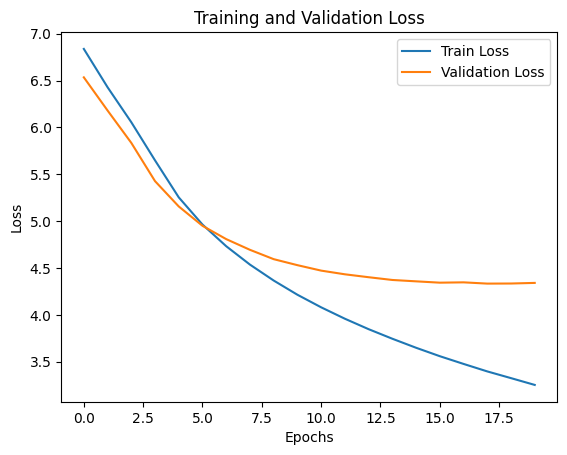

In [50]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

## **Step 4. 실제 결과와 요약문 비교하기**

In [51]:
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder.to(device)

# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)

print('=3')

=3


In [53]:
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)
print('=3')

=3


In [54]:
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)
print('=3')

=3


In [55]:
def decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, summary_max_len, device):
    # 입력을 PyTorch Tensor로 변환
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

    # 인코더 실행하여 초기 상태(hidden, cell) 얻기
    with torch.no_grad():
        e_out, e_h, e_c = encoder(input_seq)

    e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

    # <SOS>에 해당하는 토큰 생성
    target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 실행
        with torch.no_grad():
            output_tokens, h, c = decoder(target_seq, e_h, e_c)

        # 가장 높은 확률을 가진 단어 선택
        sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence
print("=3")

=3


### **모델 테스트하기**

In [56]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

print('=3')

=3


In [120]:
%%time
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 요약 :", decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, summary_max_len, device))
    print("\n")

원문 : irrfan khan currently undergoing treatment neuroendocrine tumour united kingdom reportedly start shooting shoojit sircar biopic <UNK> singh irrfan still undergoing chemotherapy responding well treatment per reports want come back fully recovered meanwhile completely ready prep film said shoojit
실제 요약 : irrfan to start shooting for <UNK> singh biopic reports
예측 요약 :  home home jail cannot million facebook have in give give indian bank him him launch


원문 : aligarh administration thursday issued notices five hindu jagran manch leaders warning found within metre radius schools christmas comes body sent letters schools warning hold christmas celebrations legal action taken case trouble reports said
실제 요약 : notices issued to hindu body over mas celebration threats
예측 요약 :  says home says says my says my was bank my for for now china my


원문 : home affairs ministry warned states union territories directly dealing countries concern directing communication routed interest national securit

<timed exec>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipykernel_8536/366614501.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


예측 요약 :  body play cannot million facebook facebook held video not million fake fake fake fake fake


원문 : archaeologists discovered nearly year old bronze pot western han dynasty tomb central china <UNK> province contains wine likely made rice litres transparent yellow colour liquid senior archaeologist said large number colour painted clay pots bronze artefacts also unearthed tomb
실제 요약 : year old wine discovered from ancient tomb in china
예측 요약 :  gold play time police under chief arrested up twitter twitter twitter fake fake fake fake


원문 : ysr congress tdp members monday skipped lunch hosted lok sabha speaker sumitra mahajan confidence motions taken discussion house speaker adjourned house happened ysr mp vijaya reddy said motion tabled parties bjp led nda centre
실제 요약 : tdp ysr skip lok sabha speaker lunch over no trust motion
예측 요약 :  says home says says congress my yrs my for for for jail china up him


원문 : european court human rights tuesday upheld belgium ban wearing islami

## **모델 테스트 결과**
- Loss가 3 ~ 4 사이로 Loss가 너무 높게 나옴
- 학습이 제대로 안 된듯 함
- CrossEntropyLoss의 경우 Loss가 1미만으로 떨어지게끔 해야 90% 이상의 정확도가 나온다고 함

## **해결방안**
- 찾아보니 각 부분(인코더, 디코더)마다 dropout을 다르게 주는 게 보통이라고 함
- 현재는 0.4로 통일된 상태
- Dropout을 다르게 설정해보자

## **모델 B 테스트**

In [131]:
# 인코더 모델 생성
encoder_B = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.3)

# 디코더 모델 생성
decoder_B = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.3)

# 모델 생성
model_B = Seq2SeqWithAttention(encoder_B, decoder_B, tar_vocab_size, hidden_size)
print(model_B)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(24000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.3)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10000, bias=True)
)


In [132]:
print(learning_rate)

0.001


In [133]:
optimizer_B = optim.AdamW(model_B.parameters(), lr=learning_rate)

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_B = model_B.to(device)

In [136]:
train_losses, val_losses = train_model(model_B, train_loader, test_loader, criterion, optimizer_B, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 6.5228 | Val Loss: 6.2810
Epoch 2/50 | Train Loss: 6.1202 | Val Loss: 5.8457
Epoch 3/50 | Train Loss: 5.6240 | Val Loss: 5.4241
Epoch 4/50 | Train Loss: 5.2405 | Val Loss: 5.1412
Epoch 5/50 | Train Loss: 4.9390 | Val Loss: 4.9313
Epoch 6/50 | Train Loss: 4.6943 | Val Loss: 4.7836
Epoch 7/50 | Train Loss: 4.4835 | Val Loss: 4.6609
Epoch 8/50 | Train Loss: 4.3007 | Val Loss: 4.5708
Epoch 9/50 | Train Loss: 4.1387 | Val Loss: 4.5053
Epoch 10/50 | Train Loss: 3.9926 | Val Loss: 4.4551
Epoch 11/50 | Train Loss: 3.8609 | Val Loss: 4.4084
Epoch 12/50 | Train Loss: 3.7386 | Val Loss: 4.3842
Epoch 13/50 | Train Loss: 3.6252 | Val Loss: 4.3648
Epoch 14/50 | Train Loss: 3.5212 | Val Loss: 4.3515
Epoch 15/50 | Train Loss: 3.4244 | Val Loss: 4.3429
Epoch 16/50 | Train Loss: 3.3335 | Val Loss: 4.3341
Epoch 17/50 | Train Loss: 3.2464 | Val Loss: 4.3399
Epoch 18/50 | Train Loss: 3.1658 | Val Loss: 4.3427
Early stopping triggered at epoch 18


### **추출적 요약 해보기**

In [98]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [73]:
!pip install summa

In [74]:
# import requests
from summa.summarizer import summarize

In [60]:
# url = "https://raw.githubusercontent.com/modulabs/Aiffel_Resources/main/matrix_synopsis.txt"
# text = requests.get(url, timeout=10).text

In [113]:
print('Summary:')
print(summarize(data['text'][0], ratio=0.5))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [114]:
print('Summary:')
print(summarize(data['text'][1], ratio=0.5))

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


# **회고**